In [2]:
import sys
sys.path.append("/home/jonas/phd/NanoNets/src/")
sys.path.append("/mnt/c/Users/jonas/Desktop/phd/NanoNets/src/")
import nanonets
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import scienceplots

In [70]:
voltages = np.random.uniform(low=-0.5, high=0.5, size=(16,3))        

def init_run(N, voltages):
    
    topology_parameter          = {}
    topology_parameter["Nx"]    = N
    topology_parameter["Ny"]    = 1
    topology_parameter["Nz"]    = 1
    # topology_parameter["e_pos"] = [[-1.5,-1.5],[1.5,1.5]]
    topology_parameter["e_pos"] = [[0,0,0],[(N-1),0,0]]
    sim_class                   = nanonets.simulation(network_topology='cubic', topology_parameter=topology_parameter, seed=0)

    sim_class.init_charge_vector(voltage_values=voltages[0])
    sim_class.init_potential_vector(voltage_values=voltages[0])
    sim_class.init_const_capacitance_values()

    # Return Model Arguments
    inv_capacitance_matrix                                                                  = sim_class.return_inv_capacitance_matrix()
    charge_vector                                                                           = sim_class.return_charge_vector()
    potential_vector                                                                        = sim_class.return_potential_vector()
    const_capacitance_values, const_capacitance_values_co1, const_capacitance_values_co2    = sim_class.return_const_capacitance_values()
    N_electrodes, N_particles                                                               = sim_class.return_particle_electrode_count()
    adv_index_rows, adv_index_cols, co_adv_index1, co_adv_index2, co_adv_index3             = sim_class.return_advanced_indices()
    temperatures, temperatures_co                                                           = sim_class.return_const_temperatures(T=0)
    resistances, resistances_co1, resistances_co2                                           = sim_class.return_random_resistances()

    # Simulation Class
    summary = nanonets.model_class(charge_vector, potential_vector, inv_capacitance_matrix, const_capacitance_values, const_capacitance_values_co1, const_capacitance_values_co2,
                            temperatures, temperatures_co, resistances, resistances_co1, resistances_co2, adv_index_rows, adv_index_cols, co_adv_index1, co_adv_index2,
                            co_adv_index3, N_electrodes, N_particles)
    
    return summary

In [71]:
voltages = np.array([[0.5,0.0,0.0]])
voltages

array([[0.5, 0. , 0. ]])

In [72]:
Ns      = np.arange(3,401)
Nss     = []
times1  = []
times1s = []
times2  = []
times2s = []
times3  = []
times3s = []

for N in Ns:

    tt1 = []
    tt2 = []
    tt3 = []

    summary = init_run(N, voltages)
    summary.calc_potentials()
    
    for i in range(100000):
        
        random_number1  = np.random.rand()
        random_number2  = np.random.rand()
        
        summary.calc_tunnel_rates_zero_T()
        summary.select_event(random_number1, random_number2)
    
    for i in range(10000):
        
        random_number1  = np.random.rand()
        random_number2  = np.random.rand()
        
        t1 = time.process_time_ns()
        summary.calc_tunnel_rates_zero_T()
        
        t2 = time.process_time_ns()
        summary.select_event(random_number1, random_number2)

        t3 = time.process_time_ns()

        tt1.append(t2-t1)
        tt2.append(t3-t2)
        tt3.append(t3-t1)

    Nss.append(len(summary.tunnel_rates))
    times1.append(np.mean(tt1))
    times1s.append(np.std(tt1))

    times2.append(np.mean(tt2))
    times2s.append(np.std(tt2))

    times3.append(np.mean(tt3))
    times3s.append(np.std(tt3))

In [63]:
results             = pd.DataFrame()
results['$N_{NP}$'] = Ns
results['$N_{T}$']  = Nss
results['t1']       = np.array(times1)/1000
results['t1s']      = np.array(times1s)/1000/np.sqrt(10000)
results['t2']       = np.array(times2)/1000
results['t2s']      = np.array(times2s)/1000/np.sqrt(10000)
results['t3']       = np.array(times3)/1000
results['t3s']      = np.array(times3s)/1000/np.sqrt(10000)
results

,$N_{NP}$,$N_{T}$,t1,t1s,t2,t2s,t3,t3s
0,3,10,1.377372,0.001043,0.999130,0.000705,2.376503,0.001386
1,4,12,1.403150,0.000849,1.016980,0.000401,2.420130,0.000992
2,5,14,1.381408,0.002263,0.988158,0.000451,2.369566,0.002333
3,6,16,1.347953,0.000921,0.999981,0.000592,2.347934,0.001175
4,7,18,1.352041,0.000921,0.996826,0.000455,2.348867,0.001091
...,...,...,...,...,...,...,...,...
393,396,796,4.450379,0.001210,1.316197,0.000644,5.766576,0.001483
394,397,798,4.460802,0.001208,1.312887,0.000553,5.773688,0.001400
395,398,800,4.579457,0.001603,1.361670,0.000650,5.941127,0.001834
396,399,802,4.465846,0.002638,1.317136,0.000638,5.782982,0.002791


In [64]:
cmeter      = 1/2.54
single_col  = 8.6

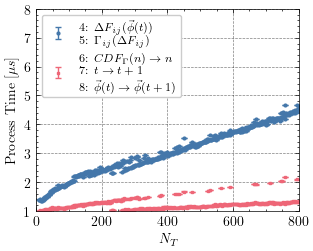

In [73]:
with plt.style.context(["science","bright", "grid"]):

    fig = plt.figure()
    fig.set_figwidth(single_col*cmeter)
    ax  = fig.add_subplot()

    ax.errorbar(x=results['$N_{T}$'],y=results['t1'], yerr=results['t1s'], marker='o', ls='',
                label='4: $\Delta F_{ij}(\\vec{\phi}(t))$ \n 5: $\Gamma_{ij}(\Delta F_{ij})$',ms=2,capsize=2)
    ax.errorbar(x=results['$N_{T}$'],y=results['t2'], yerr=results['t2s'], marker='s', ls='',
                label='6: $CDF_{\Gamma}(n) \\rightarrow n$\n 7: $t \\rightarrow t+1$ \n 8: $\\vec{\phi}(t) \\rightarrow \\vec{\phi}(t+1)$',ms=2,capsize=2)
    ax.set_xlabel('$N_{T}$')
    ax.set_ylabel('Process Time [$\mu s$]')
    ax.legend(loc='upper left', fontsize='small',frameon=True)
    ax.set_ylim(1,8)
    ax.set_xlim(0,800)
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    # fig.savefig("complexity_vs_NT.pdf", bbox_inches='tight')
    # fig.savefig("complexity_vs_NT.svg", bbox_inches='tight',transparent=True)
    plt.show()


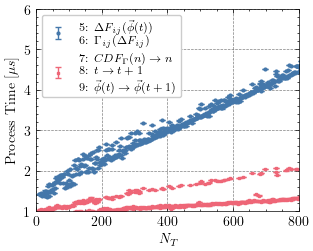

In [29]:
with plt.style.context(["science","bright", "grid"]):

    fig = plt.figure()
    fig.set_figwidth(single_col*cmeter)
    ax  = fig.add_subplot()

    ax.errorbar(x=results['$N_{T}$'],y=results['t1'], yerr=results['t1s'], marker='o', ls='',
                label='5: $\Delta F_{ij}(\\vec{\phi}(t))$ \n 6: $\Gamma_{ij}(\Delta F_{ij})$',ms=2,capsize=2)
    ax.errorbar(x=results['$N_{T}$'],y=results['t2'], yerr=results['t2s'], marker='s', ls='',
                label='7: $CDF_{\Gamma}(n) \\rightarrow n$\n 8: $t \\rightarrow t+1$ \n 9: $\\vec{\phi}(t) \\rightarrow \\vec{\phi}(t+1)$',ms=2,capsize=2)
    ax.set_xlabel('$N_{T}$')
    ax.set_ylabel('Process Time [$\mu s$]')
    ax.legend(loc='upper left', fontsize='small',frameon=True)
    ax.set_ylim(1,6)
    ax.set_xlim(0,800)
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    # fig.savefig("complexity_log_vs_NT.pdf", bbox_inches='tight')
    # fig.savefig("complexity_log_vs_NT.svg", bbox_inches='tight',transparent=True)
    plt.show()


In [ ]:
time_ = 't2'
print(np.var(np.log(results[time_]/results['N'])))
print(np.var(np.log(results[time_]/(results['N']*np.log(results['N'])))))
print(np.var(np.log(results[time_]/np.log(results['N']))))
# print(np.var(np.log(results[time_]/np.sqrt(results['N']))))

In [ ]:
times   = []
Ns      = np.arange(10000,10*10000)
for N in Ns:

    x   = np.random.uniform(-1,1,N)
    y   = np.random.uniform(-1,1,N)

    t1  = time.process_time_ns()
    z   = x+y
    t2  = time.process_time_ns()

    times.append(t2-t1)

In [ ]:
plt.plot(times, '.')
# plt.yscale('log')
# plt.xscale('log')
plt.show()

In [ ]:
import networkx as nx

In [ ]:
N_particles    = 50
N_junctions    = 4
not_connected       = True

# Generate random graphs until a graph is connected
while not_connected:

    G          = nx.random_regular_graph(N_junctions, N_particles)
    not_connected   = not(nx.is_connected(G))

G   = G.to_directed()
pos = nx.kamada_kawai_layout(G)
pos = nx.spring_layout(G, pos=pos)

In [ ]:
nx.draw_networkx(G, pos)
plt.show()

In [ ]:
G = nx.grid_graph(dim=(5,5,1))
G.nodes

In [ ]:
G_new = nx.convert_node_labels_to_integers(G)
G_new = G_new.to_directed()

In [ ]:
G_new.edges

In [ ]:
nx.draw_networkx(G_new)
plt.show()